# How to train and test DQN model class

In [12]:
#!pip install gymnasium[atari]
#!pip install gymnasium[accept-rom-license]
#!pip install "gym[accept-rom-license, atari]"
#!pip install PyVirtualDisplay

In [13]:
from DQN.DQN_model import DQNmodel
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from PIL import Image
import time

In [14]:
all_model_types = {
    "vanilla": ["1mil_50_update", 
                "500_no_ckp_50_update", 
                "avoid_finish_10000_update", 
                "final",
                "fine",
                "normal"],
    "double": [ 
                "tau=0.1",
                "tau=0.1_50_update",
                "tau=0.1_1000_update",
                "tau=0.5",
                "tau=0.8",
                "tau=1.0",
                "tau=1.0_50_update", 
                "tau=1.0_1000_update"
               ],
    "clipped_double": [
                        "tau=0.25",
                        "tau=0.5",
                        "tau=0.75",
                        "tau=1.0",
                        "tau=1.0_in_clip_avoid_finish", 
                        "tau=1.0_in_clip_eps_frac=0.4",
                        "tau=1.0_in_clip_no_avoid_finish", 
                       ]
}

In [15]:
model_type = "clipped_double"
model_detail = "tau=0.75"

model_path = f"./results/{model_type}/{model_detail}/model"
checkpoint_dir = f"./results/{model_type}/{model_detail}/checkpoints"

model = DQNmodel(
                    load_model_from=model_path,
                    checkpoint_dir=checkpoint_dir,
                    env_path="ALE/MsPacman-v5",
                    dqn_type= model_type,
                    n_env=9
                )

Restored from ./results/clipped_double/tau=0.75/checkpoints/ckpt-11
Model loaded


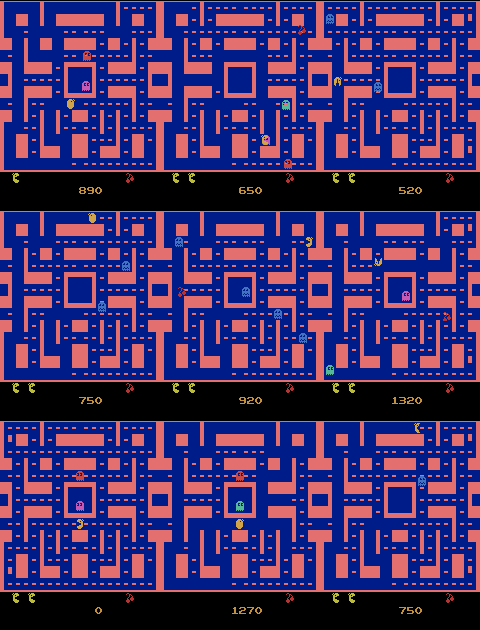

In [16]:
# Create a virtual display
display = Display(visible=0, size=(1200, 1200))
display.start()

n_env = model.n_env

data = {i: [[]] for i in range(n_env)}
lives = {i: 0 for i in range(n_env)}

obs = model.restart_env()

while True:
    actions = model.predict(obs)
    obs, rewards, dones, infos = model.env_step(actions)
    
    for i in range(n_env):
        if lives[i] < 3:
            if lives[i] >= len(data[i]):
                data[i].append([])
            
            data[i][lives[i]].append(rewards[i])

            if 'episode' in infos[i]:
                data[i].append([infos[i]['episode']['r'],
                                infos[i]['episode']['l'],
                                infos[i]['episode']['t']
                                ])
            if dones[i]:
                lives[i] += 1

    # Render the environment and display the frame
    screen = model.render_env()
    # Convert the RGB array to an image
    screen = Image.fromarray(screen)

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(screen)
    
    # Wait time to watch the game 
    time.sleep(1/4)  # Delay for 1/30 seconds to achieve ~30 fps

    if all([lives[i] >= 3 for i in range(n_env)]):
        break

ipythondisplay.clear_output(wait=True)
model.close()

In [17]:
import copy
from pprint import pprint

copy_data = copy.deepcopy(data)

episodes = 3

for i in range(n_env):
    for j in range(episodes):
        copy_data[i][j] = [sum(copy_data[i][j]), len(copy_data[i][j])]

pprint(copy_data)

for i in range(n_env):
    print("Total sub-episodes for CPU", i, ":", episodes)
    print("Total reward :", sum([copy_data[i][j][0] for j in range(episodes)]), "with average reward", format(sum([copy_data[i][j][0] for j in range(episodes)])/episodes, '.2f'))
    print('Total points :', copy_data[i][-1][0])
    print('Total len :', copy_data[i][-1][1])
    print('Total time :', copy_data[i][-1][2])
    print("Total steps :", sum([copy_data[i][j][1] for j in range(episodes)]), "with average steps", format(sum([copy_data[i][j][1] for j in range(episodes)])/episodes, '.2f'))
    print("Weighted average reward :", format(sum([copy_data[i][j][0]*copy_data[i][j][1] for j in range(episodes)])/sum([copy_data[i][j][1] for j in range(episodes)]), '.2f'))
    print()

print("General results")
print("Total sub-episodes:", sum([episodes for i in range(n_env)]))
print("Average reward :", format(sum([sum([copy_data[i][j][0] for j in range(episodes)]) for i in range(n_env)])/sum([episodes for i in range(n_env)]), '.2f'))
print("Average points :", format(sum([copy_data[i][-1][0] for i in range(n_env)])/n_env, '.2f'))
print("Average len :", format(sum([copy_data[i][-1][1] for i in range(n_env)])/n_env, '.2f'))
print("Average time :", format(sum([copy_data[i][-1][2] for i in range(n_env)])/n_env, '.2f'))
print("Average steps :", format(sum([sum([copy_data[i][j][1] for j in range(episodes)]) for i in range(n_env)])/sum([episodes for i in range(n_env)]), '.2f'))
print("Weighted average reward :", format(sum([sum([copy_data[i][j][0]*copy_data[i][j][1] for j in range(episodes)]) for i in range(n_env)])/sum([sum([copy_data[i][j][1] for j in range(episodes)]) for i in range(n_env)]), '.2f'))

{0: [[80.0, 124], [12.0, 36], [7.0, 25], [1460.0, 757, 67.585496]],
 1: [[55.0, 86], [35.0, 60], [14.0, 37], [1490.0, 743, 66.715615]],
 2: [[105.0, 159], [11.0, 42], [3.0, 28], [2630.0, 935, 82.655806]],
 3: [[63.0, 90], [14.0, 36], [34.0, 85], [2400.0, 855, 76.123756]],
 4: [[101.0, 150], [4.0, 18], [10.0, 34], [2700.0, 833, 72.71865]],
 5: [[82.0, 134], [7.0, 32], [7.0, 28], [1350.0, 787, 69.72592]],
 6: [[104.0, 163], [14.0, 66], [0.0, 38], [1950.0, 1101, 95.018113]],
 7: [[49.0, 70], [12.0, 25], [10.0, 39], [1270.0, 547, 48.395654]],
 8: [[78.0, 115], [13.0, 25], [21.0, 72], [1930.0, 869, 75.475522]]}
Total sub-episodes for CPU 0 : 3
Total reward : 99.0 with average reward 33.00
Total points : 1460.0
Total len : 757
Total time : 67.585496
Total steps : 185 with average steps 61.67
Weighted average reward : 56.90

Total sub-episodes for CPU 1 : 3
Total reward : 104.0 with average reward 34.67
Total points : 1490.0
Total len : 743
Total time : 66.715615
Total steps : 183 with averag